# Machine Learning Datasets Preparation

In [1]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sys

sys.path.append('/Users/zway/Desktop/BTC_Project/Crypto_Research/features')
from trend_indicator_pipeline_pkg import TrendIndicatorPipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline, CorrelationIndicatorPipeline, FractalDimensionPipeline

from arcticdb.version_store.helper import ArcticMemoryConfig

from arcticdb import Arctic

ModuleNotFoundError: No module named 'trend_indicator_pipeline_pkg'

In [2]:
# Load files
df_btc = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTC_daily_cleaned.csv')
df_btc.set_index('datetime', inplace=True)
df_btc = df_btc.sort_index()
df_btc['Close'] = df_btc['BTC_Close']

df_sp500 = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/SP500_daily_cleaned.csv')
df_sp500.set_index('Date', inplace=True)
df_sp500 = df_sp500.sort_index()

# DB path
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

In [3]:
# indicators simplify
trend = TrendIndicatorPipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
momentum = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
volatility = VolatilityIndicatorPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")
correlation = CorrelationIndicatorPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")
FD = FractalDimensionPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")


20250720 02:05:29.705549 20698861 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[11721]
20250720 02:05:29.706564 20698861 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[11721]
20250720 02:05:29.708586 20698861 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instanc

In [4]:
df_btc.head(), df_sp500.head()

(            Unnamed: 0     Open     High      Low  BTC_Close    Volume  \
 datetime                                                                 
 2023-01-01           0  16474.3  16581.7  16461.0    16575.5  0.113295   
 2023-01-02           1  16575.4  16754.6  16510.9    16633.6  0.511540   
 2023-01-03           2  16633.6  16732.5  16570.9    16641.2  0.020163   
 2023-01-04           3  16641.2  16952.2  16617.6    16811.9  0.247105   
 2023-01-05           4  16812.0  16839.5  16724.8    16792.4  0.016939   
 
               Close  
 datetime             
 2023-01-01  16575.5  
 2023-01-02  16633.6  
 2023-01-03  16641.2  
 2023-01-04  16811.9  
 2023-01-05  16792.4  ,
             Unnamed: 0     Open     High      Low  SP500_Close
 Date                                                          
 2023-01-03           0  3853.29  3878.46  3794.33      3824.14
 2023-01-04           1  3840.36  3873.16  3815.77      3852.97
 2023-01-05           2  3839.74  3839.74  3802.42     

In [5]:
# Set up indicators

# EMA
df_btc = trend.compute_ema(df_btc, days = 7, minute_data=False)
df_btc = trend.compute_ema(df_btc, days = 20, minute_data=False)
df_btc = trend.compute_ema(df_btc, days = 30, minute_data=False)

# SMA
df_btc = trend.compute_sma(df_btc, days = 7, minute_data=False)
df_btc = trend.compute_sma(df_btc, days = 20, minute_data=False)
df_btc = trend.compute_sma(df_btc, days = 30, minute_data=False)

# MACD - Standard: fast_days=12, slow_days=26, signal_days=9
df_btc = momentum.compute_macd(df_btc, 12, 26, 9, minute_data=False)
df_btc.rename(columns={
    'macd': 'macd_12_26',
    'macd_signal': 'macd_sig_12_26',
    'macd_diff': 'macd_hist_12_26'
}, inplace=True)

# RSI
df_btc = momentum.compute_rsi(df_btc, days=14, minute_data=False)

# Bollinger Bands
df_btc = volatility.compute_bollinger_bands(df_btc, days=20, std=2, minute_data=False)

# Average True Range
df_btc = volatility.compute_atr(df_btc, days=14, minute_data=False)

# BTC & SP500 Rolling Correlation
df_btc = correlation.compute_rolling_correlation(df_btc, df_sp500, col1='BTC_Close', col2='SP500_Close', days=7, minute_data=False)

# Fractal Dimension
df_btc = FD.apply_fd(df_btc, days=7, minute_data=False)

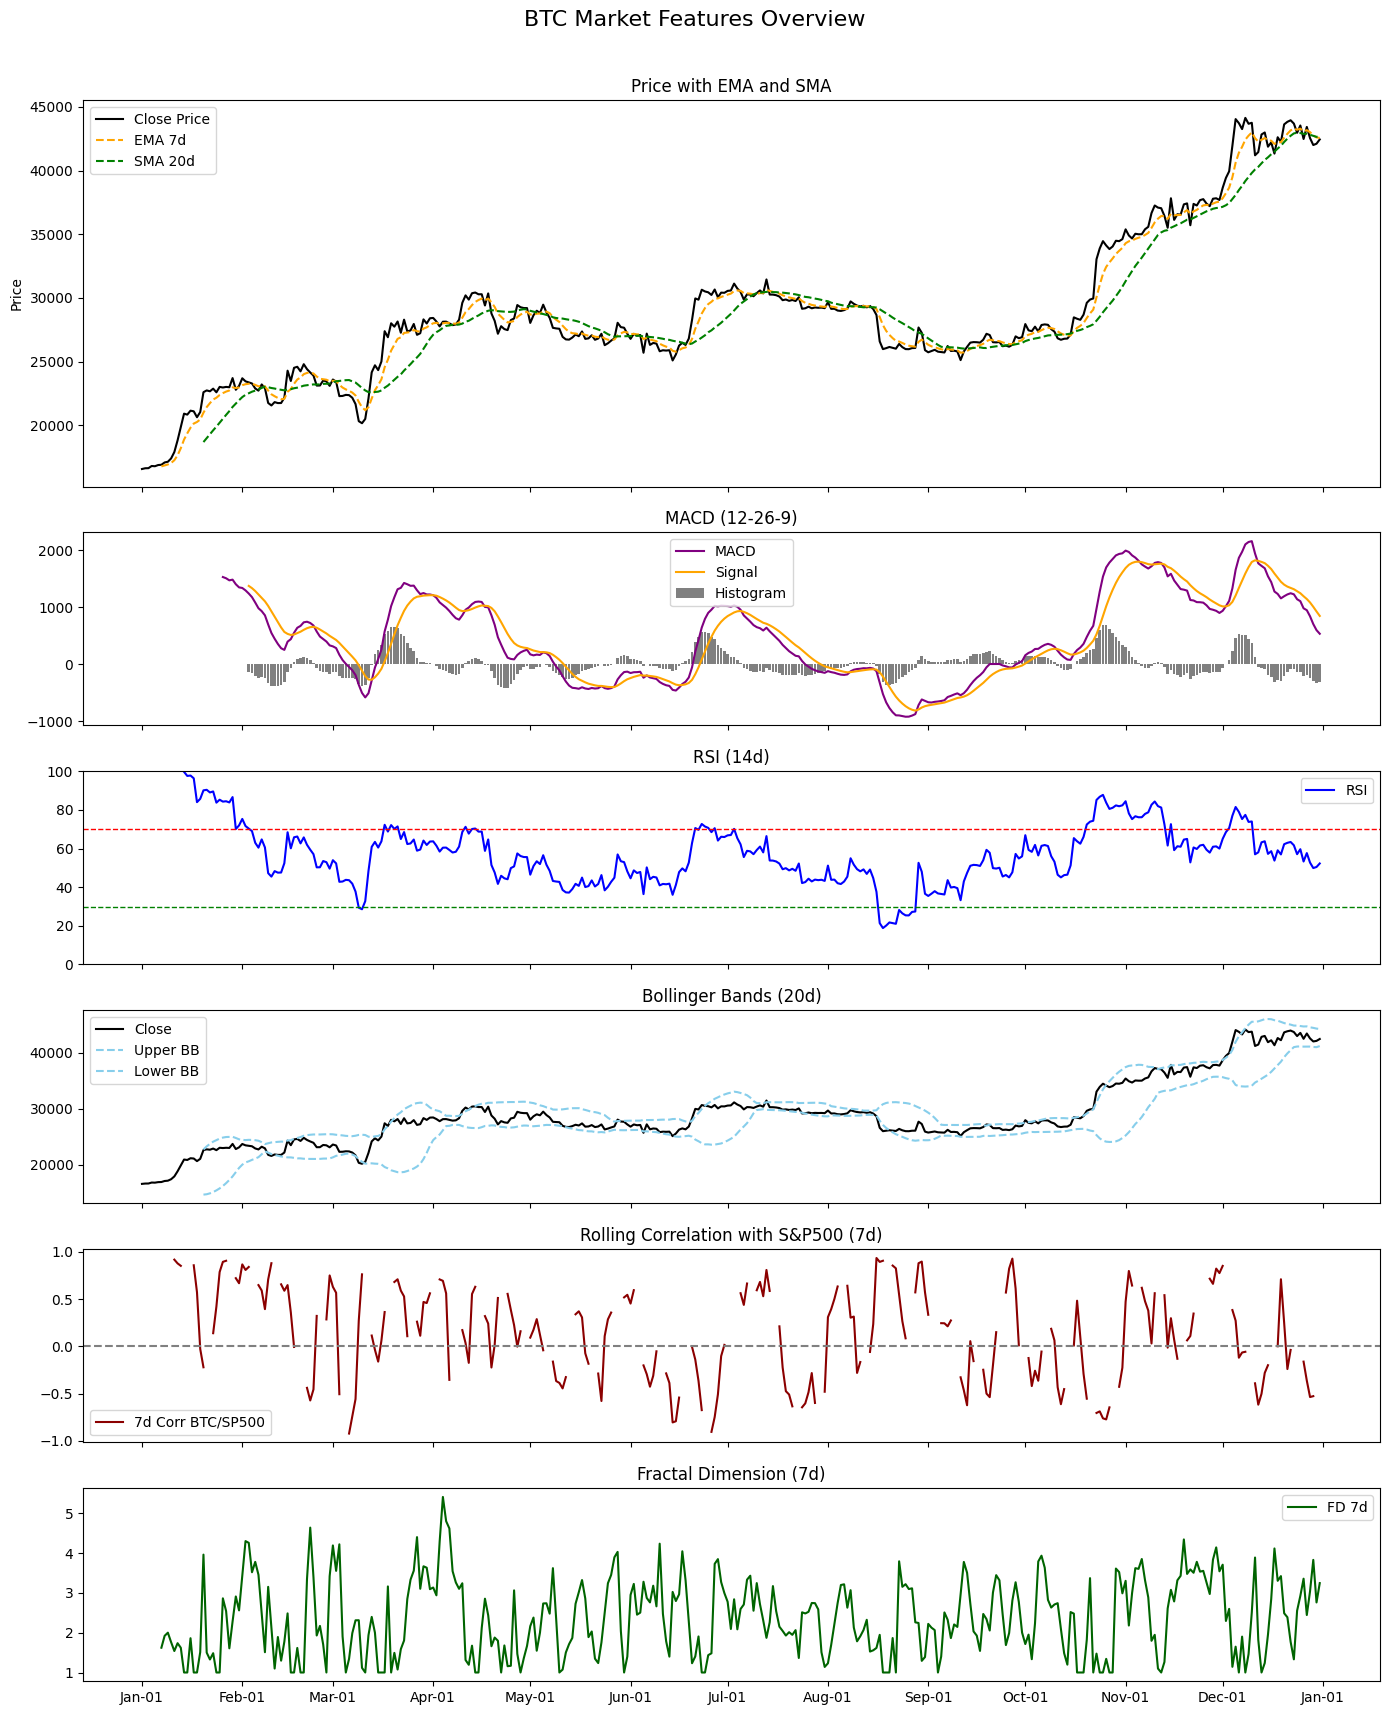

In [6]:
import matplotlib.dates as mdates

# plot layout
fig, axs = plt.subplots(6, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
fig.suptitle('BTC Market Features Overview', fontsize=16)

# Convert index to datetime if needed
df_btc.index = pd.to_datetime(df_btc.index)

# === 1. Price + EMA/SMA ===
axs[0].plot(df_btc.index, df_btc['Close'], label='Close Price', color='black')
axs[0].plot(df_btc.index, df_btc['ema_7d'], label='EMA 7d', linestyle='--', color='orange')
axs[0].plot(df_btc.index, df_btc['sma_20d'], label='SMA 20d', linestyle='--', color='green')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].set_title('Price with EMA and SMA')

# === 2. MACD ===
axs[1].plot(df_btc.index, df_btc['macd_12_26'], label='MACD', color='purple')
axs[1].plot(df_btc.index, df_btc['macd_sig_12_26'], label='Signal', color='orange')
axs[1].bar(df_btc.index, df_btc['macd_hist_12_26'], label='Histogram', color='gray')
axs[1].legend()
axs[1].set_title('MACD (12-26-9)')

# === 3. RSI ===
axs[2].plot(df_btc.index, df_btc['rsi_14d'], label='RSI', color='blue')
axs[2].axhline(70, color='red', linestyle='--', linewidth=1)
axs[2].axhline(30, color='green', linestyle='--', linewidth=1)
axs[2].set_ylim(0, 100)
axs[2].set_title('RSI (14d)')
axs[2].legend()

# === 4. Bollinger Bands ===
axs[3].plot(df_btc.index, df_btc['Close'], label='Close', color='black')
axs[3].plot(df_btc.index, df_btc['bb_upper_20d'], label='Upper BB', linestyle='--', color='skyblue')
axs[3].plot(df_btc.index, df_btc['bb_lower_20d'], label='Lower BB', linestyle='--', color='skyblue')
axs[3].set_title('Bollinger Bands (20d)')
axs[3].legend()

# === 5. BTC-SP500 Correlation ===
axs[4].plot(df_btc.index, df_btc['corr_7d'], label='7d Corr BTC/SP500', color='darkred')
axs[4].axhline(0, linestyle='--', color='gray')
axs[4].set_title('Rolling Correlation with S&P500 (7d)')
axs[4].legend()

# === 6. Fractal Dimension ===
axs[5].plot(df_btc.index, df_btc['fd_7d'], label='FD 7d', color='darkgreen')
axs[5].set_title('Fractal Dimension (7d)')
axs[5].legend()

# Format x-axis
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [7]:
# save prepared dataset
df_btc.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTC_ml_training.csv')

## Merge Datasets by Market Regime

In [8]:
# split datasets by month
for month in range(3, 13):
    df_month = df_btc[df_btc.index.month == month]
    df_month.to_csv(f'/Users/zway/Desktop/BTC_Project/Crypto_Research/data/btc_2023-{month:02d}_ML.csv')

In [9]:
# market regime classification
bull_months = ['btc_2023-03_ML.csv', 'btc_2023-06_ML.csv', 'btc_2023-10_ML.csv']
bear_months = ['btc_2023-05_ML.csv', 'btc_2023-08_ML.csv']
side_months = ['btc_2023-04_ML.csv', 'btc_2023-07_ML.csv', 'btc_2023-09_ML.csv', 'btc_2023-11_ML.csv', 'btc_2023-12_ML.csv']

In [16]:
# merge datasets
# directory
data_dir = '/Users/zway/Desktop/BTC_Project/Crypto_Research/data/'

# merge helper function
def merge_months(file_list, regime_label):
    merged = []
    for file in file_list:
        df = pd.read_csv(os.path.join(data_dir, file))
        df['regime'] = regime_label  # Add regime label
        merged.append(df)
    return pd.concat(merged, ignore_index=True)

# merge by regime
bull_df = merge_months(bull_months, 'bull')
bear_df = merge_months(bear_months, 'bear')
side_df = merge_months(side_months, 'side')
# Optionally combine all for multiclass training
full_df = pd.concat([bull_df, bear_df, side_df], ignore_index=True)


NameError: name 'bull_months' is not defined

In [13]:
# Save results to csv
bull_df.to_csv(os.path.join(data_dir, 'btc_bull_merged.csv'), index=False)
bear_df.to_csv(os.path.join(data_dir, 'btc_bear_merged.csv'), index=False)
side_df.to_csv(os.path.join(data_dir, 'btc_side_merged.csv'), index=False)
full_df.to_csv(os.path.join(data_dir, 'btc_full_regime_labeled.csv'), index=False)

## 1-min Datasets

In [19]:
# Load files
df_1min = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTCUSD_1m_2023.csv')
df_1min['Timestamp'] = pd.to_datetime(df_1min['Timestamp'])
df_1min.set_index('Timestamp', inplace=True)

# DB path
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

In [20]:
# Set up indicators

# EMA
df_1min = trend.compute_ema(df_1min, days = 7, minute_data=True)
df_1min = trend.compute_ema(df_1min, days = 20, minute_data=True)
df_1min = trend.compute_ema(df_1min, days = 30, minute_data=True)

# SMA
df_1min = trend.compute_sma(df_1min, days = 7, minute_data=True)
df_1min = trend.compute_sma(df_1min, days = 20, minute_data=True)
df_1min = trend.compute_sma(df_1min, days = 30, minute_data=True)

# MACD - Standard: fast_days=12, slow_days=26, signal_days=9
df_1min = momentum.compute_macd(df_1min, 12, 26, 9, minute_data=True)
df_1min.rename(columns={
    'macd': 'macd_12_26',
    'macd_signal': 'macd_sig_12_26',
    'macd_diff': 'macd_hist_12_26'
}, inplace=True)

# RSI
df_1min = momentum.compute_rsi(df_1min, days=14, minute_data=True)

# Bollinger Bands
df_1min = volatility.compute_bollinger_bands(df_1min, days=20, std=2, minute_data=True)

# Average True Range
df_1min = volatility.compute_atr(df_1min, days=14, minute_data=True)

# Fractal Dimension
df_1min = FD.apply_fd(df_1min, days=14, minute_data=True)

In [23]:
df_1min.dropna()

,Unnamed: 0,Open,High,Low,Close,Volume,ema_7d,ema_20d,ema_30d,sma_7d,...,sma_30d,macd_12_26,macd_sig_12_26,macd_hist_12_26,rsi_14d,bb_mid_20d,bb_upper_20d,bb_lower_20d,atr_14d,fd_14d
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-10 03:16:00,50398,21851.5,21856.5,21851.2,21853.3,2.180000e-04,22893.243714,22435.379752,21744.579540,23040.502133,...,21892.887454,839.640480,1153.758555,-314.118075,49.990289,22953.582628,23956.433515,21950.731741,11.869257,268.810
2023-02-10 03:17:00,50399,21853.2,21853.2,21851.2,21852.7,1.210000e-04,22893.037277,22435.339289,21744.584546,23040.309534,...,21892.995581,839.532846,1153.710067,-314.177222,49.990082,22953.610139,23956.296743,21950.923535,11.868773,268.788
2023-02-10 03:18:00,50400,21854.3,21855.1,21847.1,21849.9,2.980000e-04,22892.830326,22435.298635,21744.589421,23040.116806,...,21893.103674,839.425050,1153.661570,-314.236521,49.989119,22953.637677,23956.159451,21951.115903,11.868581,268.716
2023-02-10 03:19:00,50401,21849.3,21849.9,21840.3,21841.1,4.970000e-04,22892.621670,22435.257373,21744.593889,23039.922530,...,21893.211516,839.316719,1153.613064,-314.296345,49.986091,22953.665097,23956.021941,21951.308253,11.868468,268.735
2023-02-10 03:20:00,50402,21840.9,21853.0,21840.2,21845.7,3.850000e-04,22892.413968,22435.216433,21744.598570,23039.727758,...,21893.319444,839.208687,1153.564549,-314.355861,49.987674,22953.692740,23955.883441,21951.502039,11.868515,268.788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:23:00,484635,42419.1,42429.2,42419.1,42429.2,3.040000e-05,42621.028587,42321.817691,41612.238192,42798.223313,...,42134.546285,726.881256,1076.536923,-349.655668,50.105381,42625.787653,44320.470926,40931.104380,24.276436,196.438
2023-12-31 14:24:00,484636,42429.5,42433.5,42428.5,42428.5,6.000000e-06,42620.990391,42321.825099,41612.275981,42798.109425,...,42134.643850,726.828828,1076.482960,-349.654132,50.105269,42625.735649,44320.351216,40931.120083,24.275480,196.463
2023-12-31 14:25:00,484637,42428.5,42428.5,42422.6,42422.6,6.000000e-07,42620.951031,42321.832097,41612.313495,42797.995198,...,42134.741544,726.776038,1076.428997,-349.652960,50.104325,42625.683524,44320.231728,40931.135320,24.274568,196.472


In [25]:
df_1min.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTCUSD_2023-1min_ML.csv')

## label future trend

In [2]:
# load dataset
df = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTCUSD_2023-1min_ML.csv')

In [5]:
# Define forward-looking period and threshold
future_days = 5
future_window = future_days * 1440
threshold = 0.03  # 3% return

# Shift Close price N days forward
df['future_close'] = df['Close'].shift(-future_window)

# Calculate future return
df['future_return'] = (df['future_close'] - df['Close']) / df['Close']

# Define binary classification label
df['future_trend'] = (df['future_return'] > threshold).astype(int)

In [6]:
df.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTCUSD_2023-1min_ML.csv')

## Test Updated FD Pipeline on Monthly Dataset

In [3]:
# Load January 2023 monthly dataset to test updated FD pipeline
import sys
import os
import pandas as pd

# Update sys.path for current Windows environment
sys.path.append(r'E:\Coding\Crypto_Research\features')

from trend_indicator_pipeline_pkg import FractalDimensionPipeline

# Load January 2023 monthly dataset
df_jan_2023 = pd.read_csv(r'E:\Coding\Crypto_Research\data\monthly\BTCUSD_1min_2023_01.csv')
df_jan_2023['Timestamp'] = pd.to_datetime(df_jan_2023['Timestamp'])
df_jan_2023.set_index('Timestamp', inplace=True)

print(f"Loaded January 2023 dataset: {df_jan_2023.shape}")
print(f"Date range: {df_jan_2023.index.min()} to {df_jan_2023.index.max()}")
df_jan_2023.head()

Loaded January 2023 dataset: (38013, 25)
Date range: 2023-01-01 14:00:00 to 2023-01-31 23:59:00


,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,ema_7d,ema_20d,ema_30d,...,macd_hist_12_26,rsi_14d,bb_mid_20d,bb_upper_20d,bb_lower_20d,atr_14d,fd_14d,future_close,future_return,future_trend
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 14:00:00,0,0,16474.3,16475.3,16473.1,16475.3,0.000088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17180.3,0.042791,1
2023-01-01 14:01:00,1,1,16475.1,16477.7,16474.7,16476.8,0.000086,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17182.3,0.042818,1
2023-01-01 14:02:00,2,2,16477.3,16478.2,16476.4,16477.1,0.000086,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17183.2,0.042853,1
2023-01-01 14:03:00,3,3,16476.9,16478.5,16476.1,16478.2,0.000092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17181.4,0.042675,1
2023-01-01 14:04:00,4,4,16477.6,16478.9,16477.0,16478.2,0.000070,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17181.4,0.042675,1


In [4]:
# Initialize FD pipeline with updated normalization
fd_pipeline = FractalDimensionPipeline(lib_name='fractal_test', store_path=None)

print("Testing updated FD pipeline with global maximum normalization...")

# Apply FD calculation with 14-day window (like the example data)
df_jan_with_fd = fd_pipeline.apply_fd(df_jan_2023.copy(), days=14, minute_data=True)

# Check the results
fd_values = df_jan_with_fd['fd_14d'].dropna()
print(f"\\nFD Statistics:")
print(f"Count: {len(fd_values)}")
print(f"Range: {fd_values.min():.6f} to {fd_values.max():.6f}")
print(f"Mean: {fd_values.mean():.6f}")
print(f"Std: {fd_values.std():.6f}")

print(f"\\nSample FD values:")
print(fd_values.head(10))

Testing updated FD pipeline with global maximum normalization...
\nFD Statistics:
Count: 17854
Range: 0.016742 to 1.000000
Mean: 0.224820
Std: 0.273616
\nSample FD values:
Timestamp
2023-01-19 04:04:00    0.115684
2023-01-19 04:05:00    0.115849
2023-01-19 04:06:00    0.116049
2023-01-19 04:07:00    0.116301
2023-01-19 04:08:00    0.116584
2023-01-19 04:09:00    0.116710
2023-01-19 04:11:00    0.116841
2023-01-19 04:12:00    0.117070
2023-01-19 04:13:00    0.117182
2023-01-19 04:14:00    0.117386
Name: fd_14d, dtype: float64


In [ ]:
# Compare with expected values from the example dataset
print("Comparison with expected values:")
print("Expected FD range: 1.448 to 421.985")
print("Expected FD mean: ~159.8")
print("Current FD range: {:.6f} to {:.6f}".format(fd_values.min(), fd_values.max()))
print("Current FD mean: {:.6f}".format(fd_values.mean()))

# Verification that max value is 1.0 (due to global max normalization)
print(f"\\nNormalization verification:")
print(f"Max FD value: {fd_values.max():.6f} (should be 1.0)")

# Plot the FD values with BTC price overlay
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot FD on primary y-axis
color = 'darkorange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized FD', color=color)
ax1.plot(fd_values.index, fd_values.values, label='FD 14d (New Normalization)', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for BTC price
ax2 = ax1.twinx()
color = 'black'
ax2.set_ylabel('BTC Close Price', color=color)
btc_close = df_jan_with_fd['Close'].loc[fd_values.index]
ax2.plot(fd_values.index, btc_close.values, label='BTC Close', color=color, alpha=0.7, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Fractal Dimension vs BTC Price - January 2023 (Updated Pipeline)')
plt.tight_layout()
plt.show()

In [8]:
# test with whole 1-min dataset
# Load January 2023 monthly dataset
df_2023 = pd.read_csv(r'E:\Coding\Crypto_Research\data\BTCUSD_2023-1min_ML.csv')
df_2023['Timestamp'] = pd.to_datetime(df_2023['Timestamp'])
df_2023.set_index('Timestamp', inplace=True)

print(f"Loaded 2023 dataset: {df_2023.shape}")
print(f"Date range: {df_2023.index.min()} to {df_2023.index.max()}")
df_2023.head()

Loaded 2023 dataset: (484640, 25)
Date range: 2023-01-01 14:00:00 to 2023-12-31 14:27:00


,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,ema_7d,ema_20d,ema_30d,...,macd_hist_12_26,rsi_14d,bb_mid_20d,bb_upper_20d,bb_lower_20d,atr_14d,fd_14d,future_close,future_return,future_trend
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 14:00:00,0,0,16474.3,16475.3,16473.1,16475.3,0.000088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17180.3,0.042791,1
2023-01-01 14:01:00,1,1,16475.1,16477.7,16474.7,16476.8,0.000086,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17182.3,0.042818,1
2023-01-01 14:02:00,2,2,16477.3,16478.2,16476.4,16477.1,0.000086,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17183.2,0.042853,1
2023-01-01 14:03:00,3,3,16476.9,16478.5,16476.1,16478.2,0.000092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17181.4,0.042675,1
2023-01-01 14:04:00,4,4,16477.6,16478.9,16477.0,16478.2,0.000070,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17181.4,0.042675,1


In [9]:
# Initialize FD pipeline with updated normalization
fd_pipeline = FractalDimensionPipeline(lib_name='fractal_test', store_path=None)

print("Testing updated FD pipeline with global maximum normalization...")

# Apply FD calculation with 14-day window (like the example data)
df_with_fd = fd_pipeline.apply_fd(df_2023.copy(), days=14, minute_data=True)

# Check the results
fd_values = df_with_fd['fd_14d'].dropna()
print(f"\\nFD Statistics:")
print(f"Count: {len(fd_values)}")
print(f"Range: {fd_values.min():.6f} to {fd_values.max():.6f}")
print(f"Mean: {fd_values.mean():.6f}")
print(f"Std: {fd_values.std():.6f}")

print(f"\\nSample FD values:")
print(fd_values.head(10))

Testing updated FD pipeline with global maximum normalization...
\nFD Statistics:
Count: 464481
Range: 0.003431 to 1.000000
Mean: 0.378657
Std: 0.233739
\nSample FD values:
Timestamp
2023-01-19 04:04:00    0.056362
2023-01-19 04:05:00    0.056443
2023-01-19 04:06:00    0.056540
2023-01-19 04:07:00    0.056663
2023-01-19 04:08:00    0.056801
2023-01-19 04:09:00    0.056862
2023-01-19 04:11:00    0.056926
2023-01-19 04:12:00    0.057038
2023-01-19 04:13:00    0.057092
2023-01-19 04:14:00    0.057192
Name: fd_14d, dtype: float64


Comparison with expected values:
Expected FD range: 1.448 to 421.985
Expected FD mean: ~159.8
Current FD range: 0.003431 to 1.000000
Current FD mean: 0.378657
\nNormalization verification:
Max FD value: 1.000000 (should be 1.0)


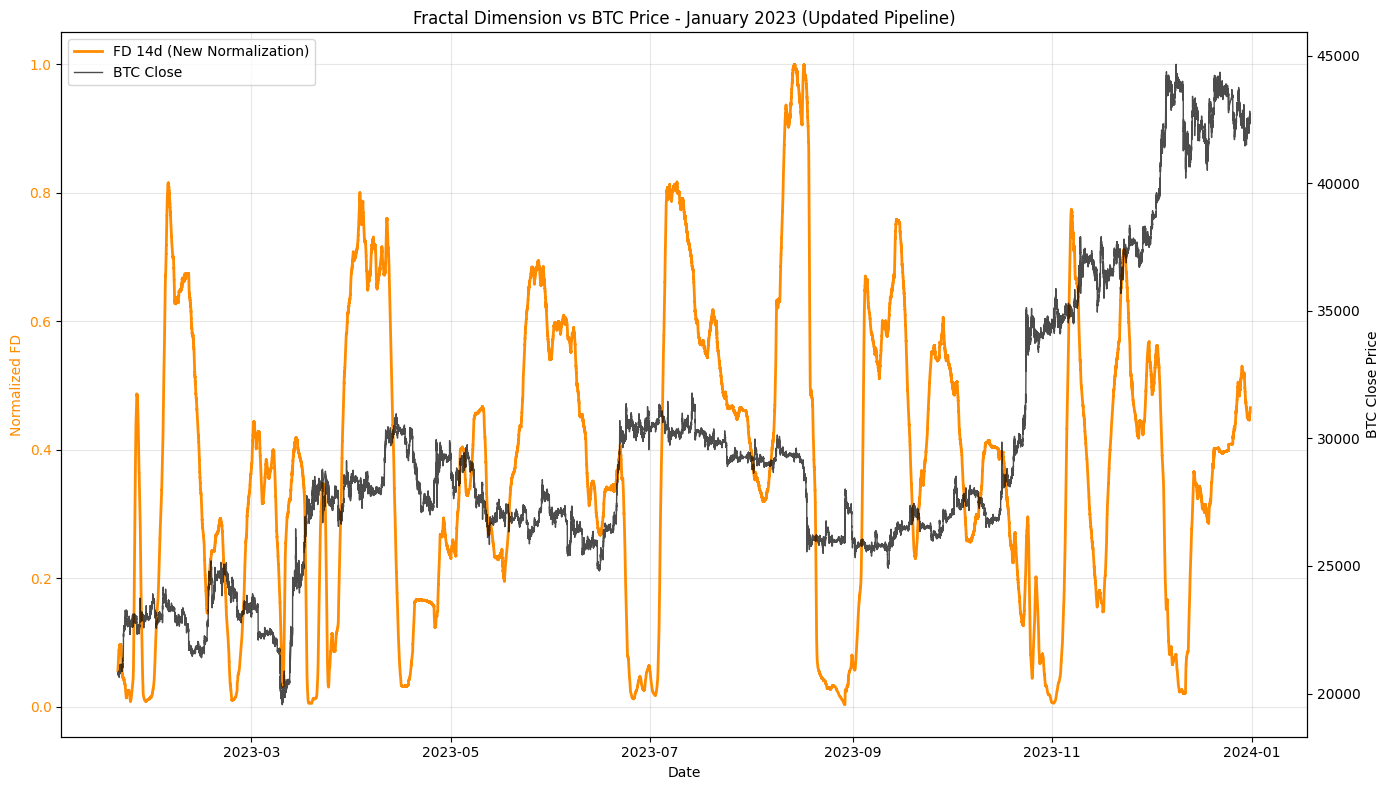

In [12]:
# Compare with expected values from the example dataset
print("Comparison with expected values:")
print("Expected FD range: 1.448 to 421.985")
print("Expected FD mean: ~159.8")
print("Current FD range: {:.6f} to {:.6f}".format(fd_values.min(), fd_values.max()))
print("Current FD mean: {:.6f}".format(fd_values.mean()))

# Verification that max value is 1.0 (due to global max normalization)
print(f"\\nNormalization verification:")
print(f"Max FD value: {fd_values.max():.6f} (should be 1.0)")

# Plot the FD values with BTC price overlay
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot FD on primary y-axis
color = 'darkorange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized FD', color=color)
ax1.plot(fd_values.index, fd_values.values, label='FD 14d (New Normalization)', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for BTC price
ax2 = ax1.twinx()
color = 'black'
ax2.set_ylabel('BTC Close Price', color=color)
btc_close = df_with_fd['Close'].loc[fd_values.index]
ax2.plot(fd_values.index, btc_close.values, label='BTC Close', color=color, alpha=0.7, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Fractal Dimension vs BTC Price - January 2023 (Updated Pipeline)')
plt.tight_layout()
plt.show()

In [19]:

df_with_fd.to_csv(os.path.join('E:\Coding\Crypto_Research\data\BTCUSD_2023-1min_correct_fd.csv'), index=False)


## Add 7-days FD as faster indicator
## Add 30-days FD as long-term indicator

In [2]:
# Load pre-processed dataset - BTC-USD 2023 1-min bar (with wrong fd_14d)
import sys
import os
import pandas as pd

# Update sys.path for current Windows environment
sys.path.append(r'E:\Coding\Crypto_Research\features')

from trend_indicator_pipeline_pkg import FractalDimensionPipeline

# Load BTCUSD_2023-1min_ML.csv
df = pd.read_csv(r'E:\Coding\Crypto_Research\data\BTCUSD_2023-1min_ML.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

print(f"Loaded 2023 dataset: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()

Loaded 2023 dataset: (484640, 25)
Date range: 2023-01-01 14:00:00 to 2023-12-31 14:27:00


,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,ema_7d,ema_20d,ema_30d,...,macd_hist_12_26,rsi_14d,bb_mid_20d,bb_upper_20d,bb_lower_20d,atr_14d,fd_14d,future_close,future_return,future_trend
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 14:00:00,0,0,16474.3,16475.3,16473.1,16475.3,0.000088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17180.3,0.042791,1
2023-01-01 14:01:00,1,1,16475.1,16477.7,16474.7,16476.8,0.000086,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17182.3,0.042818,1
2023-01-01 14:02:00,2,2,16477.3,16478.2,16476.4,16477.1,0.000086,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17183.2,0.042853,1
2023-01-01 14:03:00,3,3,16476.9,16478.5,16476.1,16478.2,0.000092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17181.4,0.042675,1
2023-01-01 14:04:00,4,4,16477.6,16478.9,16477.0,16478.2,0.000070,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,17181.4,0.042675,1


In [3]:
# Initialize FD pipeline with updated normalization
fd_pipeline = FractalDimensionPipeline(lib_name='fractal_test', store_path=None)


In [4]:
# Compute FD for multiple timeframes: 7, 14, and 30 days
print("Computing Fractal Dimension indicators...")
print(f"Dataset shape before FD: {df.shape}")

# Apply FD calculations for different windows
df_with_fd = fd_pipeline.apply_fd(df.copy(), days=7, minute_data=True, use_parallel=True)
print("FD 7d completed")

df_with_fd = fd_pipeline.apply_fd(df_with_fd.copy(), days=14, minute_data=True, use_parallel=True) 
print("FD 14d completed")

df_with_fd = fd_pipeline.apply_fd(df_with_fd.copy(), days=30, minute_data=True, use_parallel=True)
print("FD 30d completed")

print(f"Dataset shape after FD: {df_with_fd.shape}")

# Check FD statistics
for fd_col in ['fd_7d', 'fd_14d', 'fd_30d']:
    if fd_col in df_with_fd.columns:
        fd_values = df_with_fd[fd_col].dropna()
        print(f"\n{fd_col} Statistics:")
        print(f"  Count: {len(fd_values):,}")
        print(f"  Range: {fd_values.min():.6f} to {fd_values.max():.6f}")
        print(f"  Mean: {fd_values.mean():.6f}")
        print(f"  Std: {fd_values.std():.6f}")

# Save the updated dataset with all FD indicators
output_path = r'E:\Coding\Crypto_Research\data\BTCUSD_2023-1min_ML_with_FDs.csv'
df_with_fd.to_csv(output_path)
print(f"\nDataset saved to: {output_path}")
print("All FD indicators (7d, 14d, 30d) have been computed and saved!")

Computing Fractal Dimension indicators...
Dataset shape before FD: (484640, 25)
FD 7d completed
FD 14d completed
FD 30d completed
Dataset shape after FD: (484640, 27)

fd_7d Statistics:
  Count: 474,561
  Range: 0.005465 to 1.000000
  Mean: 0.403358
  Std: 0.227642

fd_14d Statistics:
  Count: 464,481
  Range: 0.003431 to 1.000000
  Mean: 0.378657
  Std: 0.233739

fd_30d Statistics:
  Count: 441,441
  Range: 0.004174 to 1.000000
  Mean: 0.332389
  Std: 0.230913

Dataset saved to: E:\Coding\Crypto_Research\data\BTCUSD_2023-1min_ML_with_FDs.csv
All FD indicators (7d, 14d, 30d) have been computed and saved!
